## 1. 准备环境与导入库

In [ ]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
# 设置 Hugging Face 镜像源，解决连接超时问题
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"

import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup

# 2. 设置随机种子
def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# 3. 选择设备
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using device: mps (Apple Silicon)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using device: cuda")
else:
    device = torch.device("cpu")
    print("Using device: cpu")

## 2. 数据读取与处理

In [ ]:
# 读取数据
data_path = "../DATA/dataset.json"
with open(data_path, "r", encoding="utf-8") as f:
    records = json.load(f)
print(f"Total samples: {len(records)}")

# --- BERT Dataset ---
class NewsBertDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def prepare_bert_data(records, text_key, tokenizer, max_len=64):
    df = pd.DataFrame(records)
    texts = df[text_key].fillna("").tolist()
    labels_raw = df["category"].tolist()
    
    # Label Mapping
    unique_labels = sorted(set(labels_raw))
    label2id = {label: i for i, label in enumerate(unique_labels)}
    id2label = {i: label for label, i in label2id.items()}
    labels = [label2id[l] for l in labels_raw]

    dataset = NewsBertDataset(texts, labels, tokenizer, max_len)
    
    # Split
    total_size = len(dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    meta_size = total_size - train_size - val_size
    
    train_ds, val_ds, meta_ds = random_split(
        dataset, [train_size, val_size, meta_size], 
        generator=torch.Generator().manual_seed(42)
    )
    
    return train_ds, val_ds, meta_ds, label2id, id2label

## 3. BERT 模型定义

In [ ]:
class BertNewsClassifier(nn.Module):
    def __init__(self, num_labels):
        super(BertNewsClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # 使用 pooled_output (CLS token 的 embedding 经过一个线性层和 Tanh)
        pooled_output = outputs.pooler_output
        output = self.drop(pooled_output)
        return self.out(output)

## 4. 训练流程

In [ ]:
import time

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples, epoch=1, num_epochs=1, log_every=2000):
    model = model.train()
    losses = []
    correct_predictions = 0

    for step, d in enumerate(data_loader, start=1):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        if step % log_every == 0:
             print(f"Epoch {epoch}/{num_epochs} | Step {step}/{len(data_loader)} | loss={loss.item():.4f}")

    # MPS 不支持 float64 (double)，改为 float (float32)
    return correct_predictions.float() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    # MPS 不支持 float64 (double)，改为 float (float32)
    return correct_predictions.float() / n_examples, np.mean(losses)

def run_bert_training(text_key, save_name, epochs=2, batch_size=16):
    print(f"\n{'='*20} Training BERT on {text_key} {'='*20}")
    start_time = time.time()
    
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    train_ds, val_ds, meta_ds, label2id, id2label = prepare_bert_data(records, text_key, tokenizer)
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    
    model = BertNewsClassifier(len(label2id)).to(device)
    
    # 使用 torch.optim.AdamW 替代 transformers.AdamW
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )
    loss_fn = nn.CrossEntropyLoss().to(device)
    
    best_accuracy = 0
    history = {
        'train_acc': [],
        'train_loss': [],
        'val_acc': [],
        'val_loss': []
    }
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        train_acc, train_loss = train_epoch(
            model, train_loader, loss_fn, optimizer, device, scheduler, len(train_ds), epoch=epoch+1, num_epochs=epochs
        )
        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(
            model, val_loader, loss_fn, device, len(val_ds)
        )
        print(f'Val   loss {val_loss} accuracy {val_acc}')
        
        # Record history
        history['train_acc'].append(train_acc.item())
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc.item())
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            torch.save({
                'model_state_dict': model.state_dict(),
                'label2id': label2id,
                'id2label': id2label,
                'config': {'text_key': text_key}
            }, save_name)
            print(f"Saved best model to {save_name}")
            
    end_time = time.time()
    print(f"Training finished in {end_time - start_time:.2f}s")
    return best_accuracy, history

def plot_training_history(history, title="Training History"):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

Epoch 1/6
Epoch 1/6 | Step 2000/9167 | loss=0.9660
Epoch 1/6 | Step 4000/9167 | loss=0.7488
Epoch 1/6 | Step 6000/9167 | loss=0.6536
Epoch 1/6 | Step 8000/9167 | loss=0.6174
Train loss 0.8244622516663941 accuracy 0.7246775031089783
Val   loss 0.7096951864906244 accuracy 0.7594578266143799
Saved best model to ../Results/bert/best_bert_headline.pt
Epoch 2/6
Epoch 2/6 | Step 2000/9167 | loss=0.3633
Epoch 2/6 | Step 4000/9167 | loss=0.6986
Epoch 2/6 | Step 6000/9167 | loss=1.0204
Epoch 2/6 | Step 8000/9167 | loss=0.2543
Train loss 0.5729047055363824 accuracy 0.8079744577407837
Val   loss 0.7013574307580637 accuracy 0.766489565372467
Saved best model to ../Results/bert/best_bert_headline.pt
Epoch 3/6
Epoch 3/6 | Step 2000/9167 | loss=0.5142
Epoch 3/6 | Step 4000/9167 | loss=0.5093
Epoch 3/6 | Step 6000/9167 | loss=0.7955
Epoch 3/6 | Step 8000/9167 | loss=0.9520
Train loss 0.39785943381602923 accuracy 0.868205726146698
Val   loss 0.8028432801460643 accuracy 0.7639123201370239
Epoch 4/6
Epoch

Epoch 1/6
Epoch 1/6 | Step 2000/9167 | loss=0.9660
Epoch 1/6 | Step 4000/9167 | loss=0.7488
Epoch 1/6 | Step 6000/9167 | loss=0.6536
Epoch 1/6 | Step 8000/9167 | loss=0.6174
Train loss 0.8244622516663941 accuracy 0.7246775031089783
Val   loss 0.7096951864906244 accuracy 0.7594578266143799
Saved best model to ../Results/bert/best_bert_headline.pt
Epoch 2/6
Epoch 2/6 | Step 2000/9167 | loss=0.3633
Epoch 2/6 | Step 4000/9167 | loss=0.6986
Epoch 2/6 | Step 6000/9167 | loss=1.0204
Epoch 2/6 | Step 8000/9167 | loss=0.2543
Train loss 0.5729047055363824 accuracy 0.8079744577407837
Val   loss 0.7013574307580637 accuracy 0.766489565372467
Saved best model to ../Results/bert/best_bert_headline.pt
Epoch 3/6
Epoch 3/6 | Step 2000/9167 | loss=0.5142
Epoch 3/6 | Step 4000/9167 | loss=0.5093
Epoch 3/6 | Step 6000/9167 | loss=0.7955
Epoch 3/6 | Step 8000/9167 | loss=0.9520
Train loss 0.39785943381602923 accuracy 0.868205726146698
Val   loss 0.8028432801460643 accuracy 0.7639123201370239
Epoch 4/6
Epoch

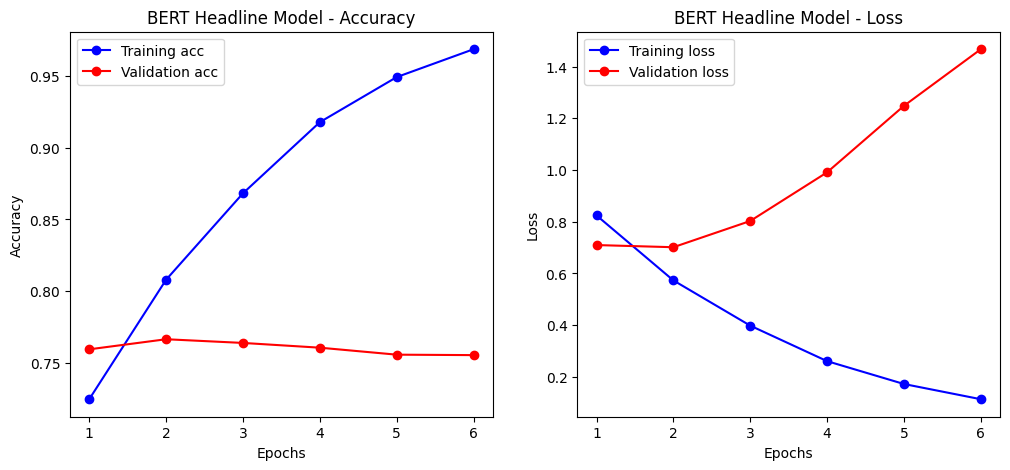

Epoch 1/6
Epoch 1/6 | Step 2000/9167 | loss=0.9660
Epoch 1/6 | Step 4000/9167 | loss=0.7488
Epoch 1/6 | Step 6000/9167 | loss=0.6536
Epoch 1/6 | Step 8000/9167 | loss=0.6174
Train loss 0.8244622516663941 accuracy 0.7246775031089783
Val   loss 0.7096951864906244 accuracy 0.7594578266143799
Saved best model to ../Results/bert/best_bert_headline.pt
Epoch 2/6
Epoch 2/6 | Step 2000/9167 | loss=0.3633
Epoch 2/6 | Step 4000/9167 | loss=0.6986
Epoch 2/6 | Step 6000/9167 | loss=1.0204
Epoch 2/6 | Step 8000/9167 | loss=0.2543
Train loss 0.5729047055363824 accuracy 0.8079744577407837
Val   loss 0.7013574307580637 accuracy 0.766489565372467
Saved best model to ../Results/bert/best_bert_headline.pt
Epoch 3/6
Epoch 3/6 | Step 2000/9167 | loss=0.5142
Epoch 3/6 | Step 4000/9167 | loss=0.5093
Epoch 3/6 | Step 6000/9167 | loss=0.7955
Epoch 3/6 | Step 8000/9167 | loss=0.9520
Train loss 0.39785943381602923 accuracy 0.868205726146698
Val   loss 0.8028432801460643 accuracy 0.7639123201370239
Epoch 4/6
Epoch

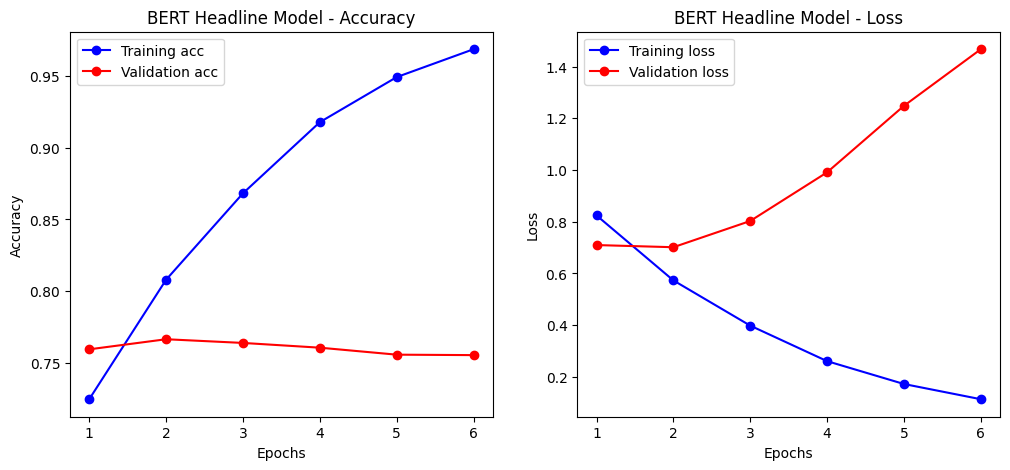


==================== Training BERT on short_description ====================
Epoch 1/6
Epoch 1/6 | Step 2000/9167 | loss=1.5034
Epoch 1/6 | Step 4000/9167 | loss=1.0639
Epoch 1/6 | Step 6000/9167 | loss=0.5433
Epoch 1/6 | Step 8000/9167 | loss=0.7317
Train loss 1.079073762879372 accuracy 0.6289715766906738
Val   loss 0.993346537441091 accuracy 0.655381977558136
Saved best model to ../Results/bert/best_bert_description.pt
Epoch 2/6
Epoch 2/6 | Step 2000/9167 | loss=1.0221
Epoch 2/6 | Step 4000/9167 | loss=0.6099
Epoch 2/6 | Step 6000/9167 | loss=0.6824
Epoch 2/6 | Step 8000/9167 | loss=0.5170
Train loss 0.8461115227991276 accuracy 0.7087981104850769
Val   loss 1.014595917754501 accuracy 0.6578637361526489
Saved best model to ../Results/bert/best_bert_description.pt
Epoch 3/6
Epoch 3/6 | Step 2000/9167 | loss=0.6880
Epoch 3/6 | Step 4000/9167 | loss=0.3183
Epoch 3/6 | Step 6000/9167 | loss=0.5658
Epoch 3/6 | Step 8000/9167 | loss=0.4826
Train loss 0.6488186405664625 accuracy 0.777736127

Epoch 1/6
Epoch 1/6 | Step 2000/9167 | loss=0.9660
Epoch 1/6 | Step 4000/9167 | loss=0.7488
Epoch 1/6 | Step 6000/9167 | loss=0.6536
Epoch 1/6 | Step 8000/9167 | loss=0.6174
Train loss 0.8244622516663941 accuracy 0.7246775031089783
Val   loss 0.7096951864906244 accuracy 0.7594578266143799
Saved best model to ../Results/bert/best_bert_headline.pt
Epoch 2/6
Epoch 2/6 | Step 2000/9167 | loss=0.3633
Epoch 2/6 | Step 4000/9167 | loss=0.6986
Epoch 2/6 | Step 6000/9167 | loss=1.0204
Epoch 2/6 | Step 8000/9167 | loss=0.2543
Train loss 0.5729047055363824 accuracy 0.8079744577407837
Val   loss 0.7013574307580637 accuracy 0.766489565372467
Saved best model to ../Results/bert/best_bert_headline.pt
Epoch 3/6
Epoch 3/6 | Step 2000/9167 | loss=0.5142
Epoch 3/6 | Step 4000/9167 | loss=0.5093
Epoch 3/6 | Step 6000/9167 | loss=0.7955
Epoch 3/6 | Step 8000/9167 | loss=0.9520
Train loss 0.39785943381602923 accuracy 0.868205726146698
Val   loss 0.8028432801460643 accuracy 0.7639123201370239
Epoch 4/6
Epoch

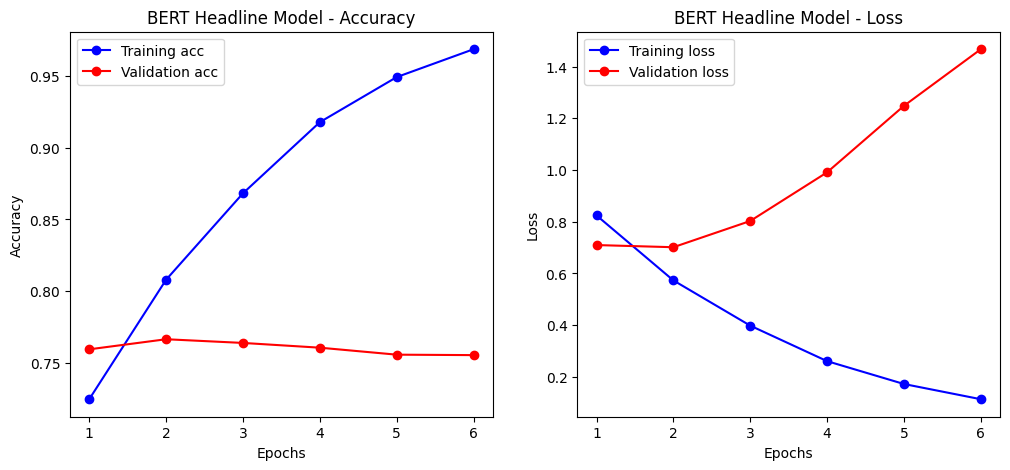


==================== Training BERT on short_description ====================
Epoch 1/6
Epoch 1/6 | Step 2000/9167 | loss=1.5034
Epoch 1/6 | Step 4000/9167 | loss=1.0639
Epoch 1/6 | Step 6000/9167 | loss=0.5433
Epoch 1/6 | Step 8000/9167 | loss=0.7317
Train loss 1.079073762879372 accuracy 0.6289715766906738
Val   loss 0.993346537441091 accuracy 0.655381977558136
Saved best model to ../Results/bert/best_bert_description.pt
Epoch 2/6
Epoch 2/6 | Step 2000/9167 | loss=1.0221
Epoch 2/6 | Step 4000/9167 | loss=0.6099
Epoch 2/6 | Step 6000/9167 | loss=0.6824
Epoch 2/6 | Step 8000/9167 | loss=0.5170
Train loss 0.8461115227991276 accuracy 0.7087981104850769
Val   loss 1.014595917754501 accuracy 0.6578637361526489
Saved best model to ../Results/bert/best_bert_description.pt
Epoch 3/6
Epoch 3/6 | Step 2000/9167 | loss=0.6880
Epoch 3/6 | Step 4000/9167 | loss=0.3183
Epoch 3/6 | Step 6000/9167 | loss=0.5658
Epoch 3/6 | Step 8000/9167 | loss=0.4826
Train loss 0.6488186405664625 accuracy 0.777736127

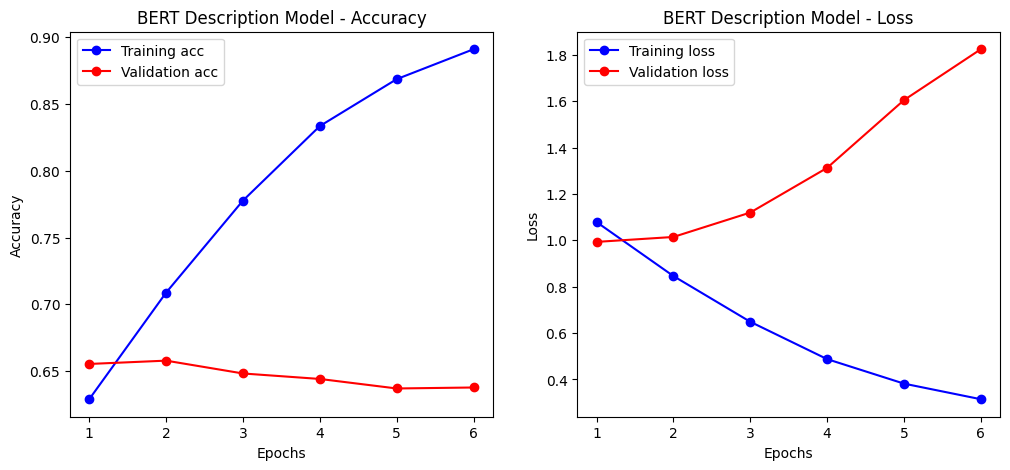

In [10]:
# --- 运行训练 (串行，因为 BERT 显存占用大) ---
# 确保目录存在
os.makedirs("../Results/bert", exist_ok=True)

epochs = 6

# 训练 Headline 模型
acc_h, history_h = run_bert_training(
    text_key="headline", 
    save_name="../Results/bert/best_bert_headline.pt", 
    epochs=epochs, 
    batch_size=16 # 如果显存不足，调小此值
)
plot_training_history(history_h, title="BERT Headline Model")

# 训练 Description 模型
acc_d, history_d = run_bert_training(
    text_key="short_description", 
    save_name="../Results/bert/best_bert_description.pt", 
    epochs=epochs, 
    batch_size=16
)
plot_training_history(history_d, title="BERT Description Model")

Loading Best Headline Model for Evaluation...


Loading Best Headline Model for Evaluation...


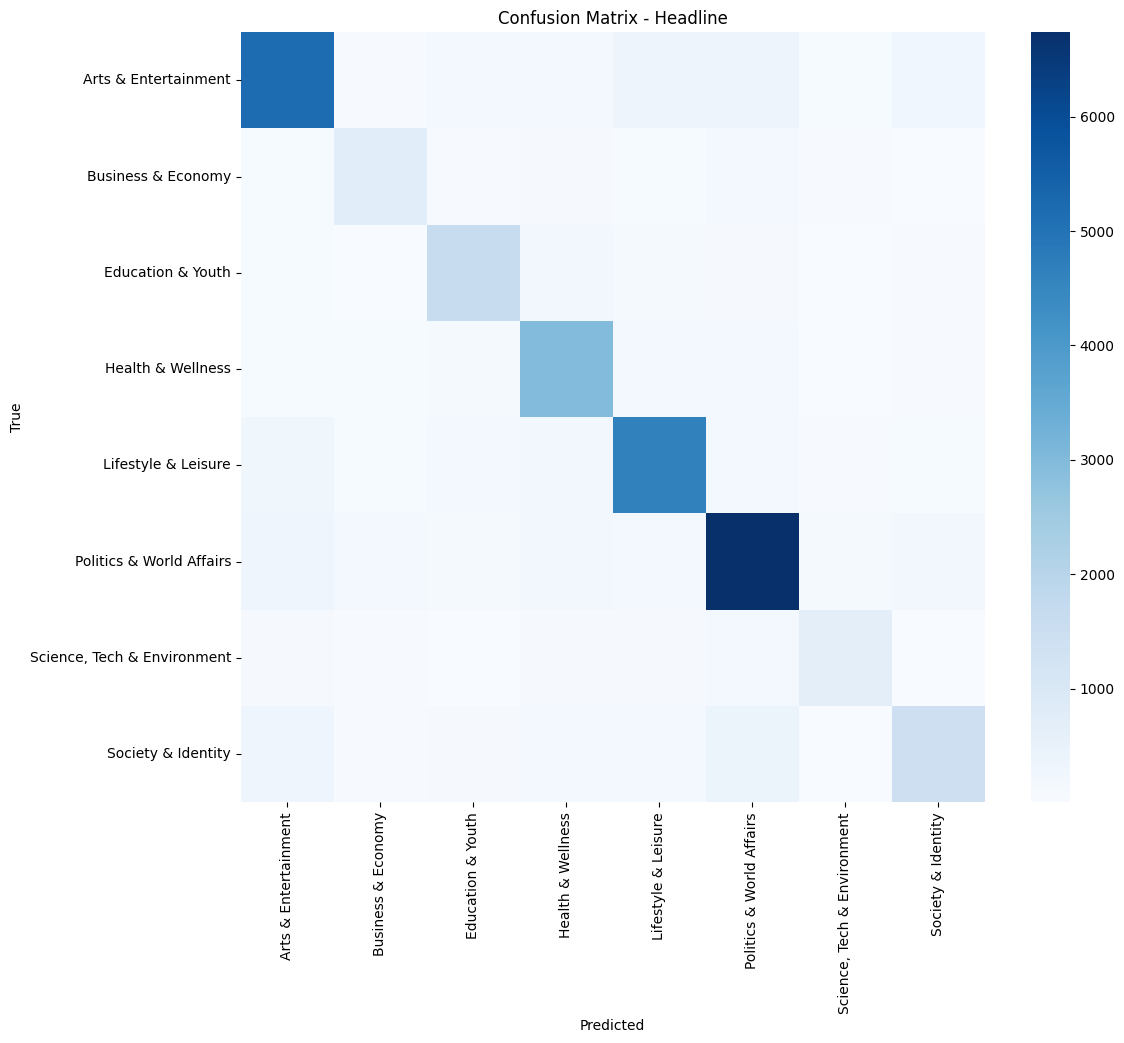

Loading Best Headline Model for Evaluation...


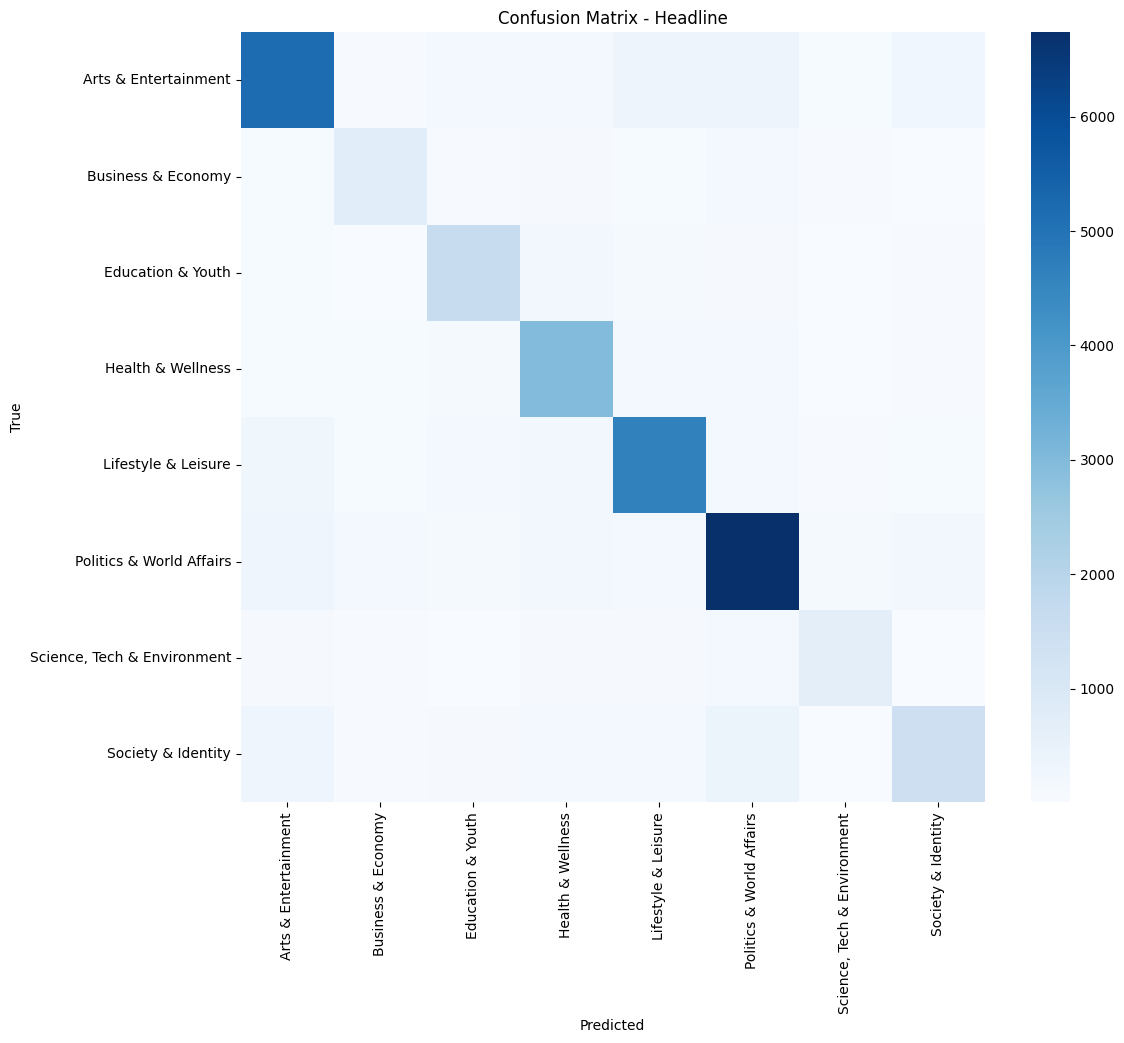

                             precision    recall  f1-score   support

       Arts & Entertainment       0.80      0.78      0.79      6642
         Business & Economy       0.62      0.61      0.62      1219
          Education & Youth       0.68      0.74      0.71      2197
          Health & Wellness       0.72      0.82      0.77      3661
        Lifestyle & Leisure       0.80      0.82      0.81      5689
   Politics & World Affairs       0.81      0.83      0.82      8074
Science, Tech & Environment       0.67      0.56      0.61      1266
         Society & Identity       0.69      0.55      0.61      2681

                   accuracy                           0.77     31429
                  macro avg       0.72      0.71      0.72     31429
               weighted avg       0.77      0.77      0.76     31429

Loading Best Description Model for Evaluation...


Loading Best Headline Model for Evaluation...


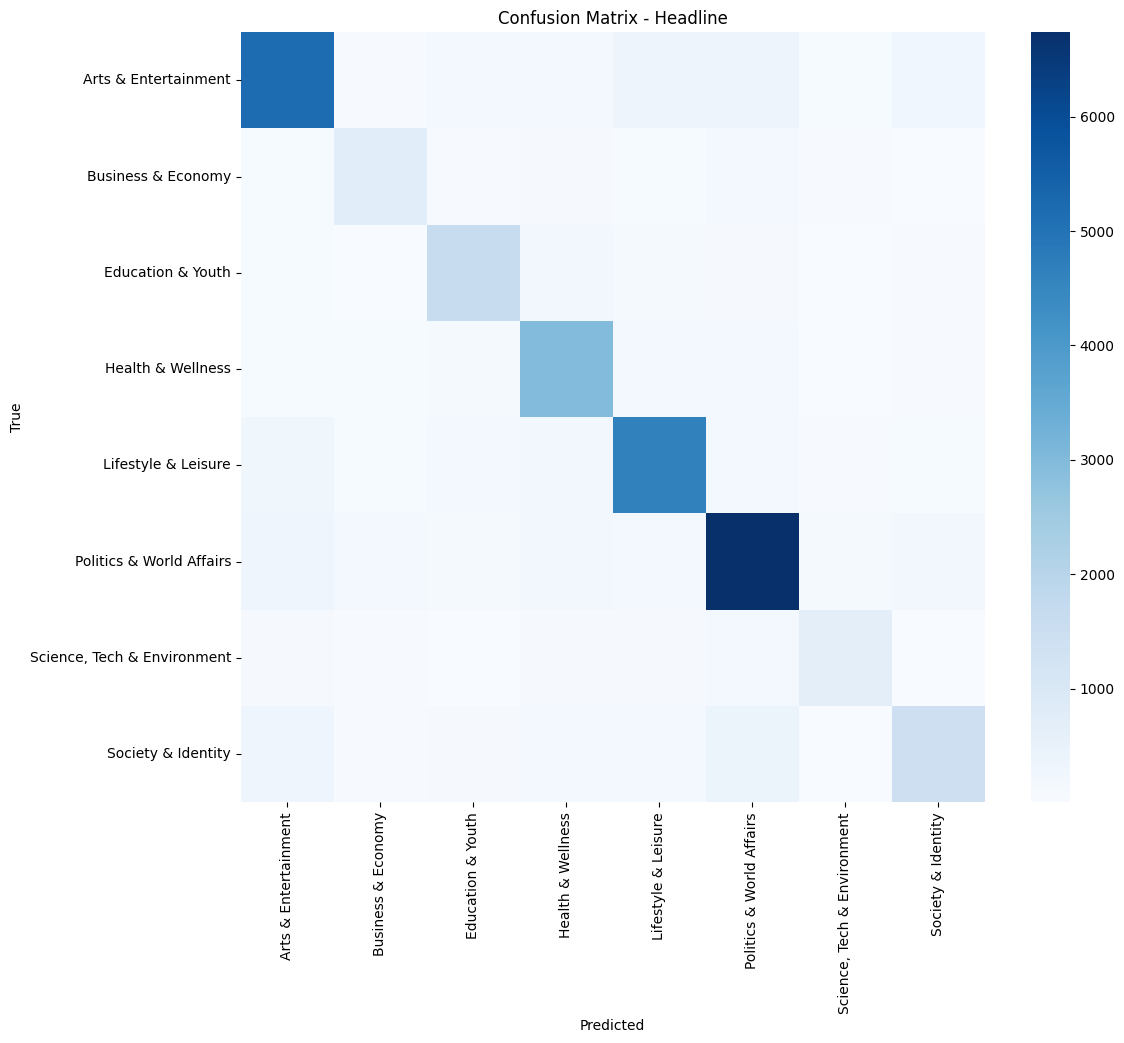

                             precision    recall  f1-score   support

       Arts & Entertainment       0.80      0.78      0.79      6642
         Business & Economy       0.62      0.61      0.62      1219
          Education & Youth       0.68      0.74      0.71      2197
          Health & Wellness       0.72      0.82      0.77      3661
        Lifestyle & Leisure       0.80      0.82      0.81      5689
   Politics & World Affairs       0.81      0.83      0.82      8074
Science, Tech & Environment       0.67      0.56      0.61      1266
         Society & Identity       0.69      0.55      0.61      2681

                   accuracy                           0.77     31429
                  macro avg       0.72      0.71      0.72     31429
               weighted avg       0.77      0.77      0.76     31429

Loading Best Description Model for Evaluation...


'(MaxRetryError("HTTPSConnectionPool(host='hf-mirror.com', port=443): Max retries exceeded with url: /bert-base-uncased/resolve/main/config.json (Caused by ProxyError('Unable to connect to proxy', RemoteDisconnected('Remote end closed connection without response')))"), '(Request ID: d5006281-dd29-4a6e-8495-2a3605671df9)')' thrown while requesting HEAD https://hf-mirror.com/bert-base-uncased/resolve/main/config.json
Retrying in 1s [Retry 1/5].
'(MaxRetryError("HTTPSConnectionPool(host='hf-mirror.com', port=443): Max retries exceeded with url: /bert-base-uncased/resolve/main/config.json (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1032)')))"), '(Request ID: 65adf37d-d513-4cfe-aae9-ab79c091bd4d)')' thrown while requesting HEAD https://hf-mirror.com/bert-base-uncased/resolve/main/config.json
Retrying in 2s [Retry 2/5].
'(ReadTimeoutError("HTTPSConnectionPool(host='hf-mirror.com', port=443): Read timed out. (read timeo

In [ ]:
# --- 混淆矩阵可视化 (Confusion Matrix) ---
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, data_loader, device, label2id, title="Confusion Matrix"):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            
            predictions.extend(preds.cpu().tolist())
            true_labels.extend(targets.cpu().tolist())
            
    cm = confusion_matrix(true_labels, predictions)
    class_names = [k for k, v in sorted(label2id.items(), key=lambda item: item[1])]
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()
    
    print(classification_report(true_labels, predictions, target_names=class_names))

# 加载最佳模型并绘制混淆矩阵
# 1. Headline Model
print("Loading Best Headline Model for Evaluation...")
checkpoint_h = torch.load("../Results/bert/best_bert_headline.pt", map_location=device)
model_h = BertNewsClassifier(len(checkpoint_h['label2id'])).to(device)
model_h.load_state_dict(checkpoint_h['model_state_dict'])

# 需要重新准备验证集 DataLoader (因为之前的 loader 可能已经被销毁或需要重置)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
_, val_ds, _, _, _ = prepare_bert_data(records, "headline", tokenizer)
val_loader_h = DataLoader(val_ds, batch_size=16)

plot_confusion_matrix(model_h, val_loader_h, device, checkpoint_h['label2id'], title="Confusion Matrix - Headline")

# 2. Description Model
print("Loading Best Description Model for Evaluation...")
checkpoint_d = torch.load("../Results/bert/best_bert_description.pt", map_location=device)
model_d = BertNewsClassifier(len(checkpoint_d['label2id'])).to(device)
model_d.load_state_dict(checkpoint_d['model_state_dict'])

_, val_ds_d, _, _, _ = prepare_bert_data(records, "short_description", tokenizer)
val_loader_d = DataLoader(val_ds_d, batch_size=16)

plot_confusion_matrix(model_d, val_loader_d, device, checkpoint_d['label2id'], title="Confusion Matrix - Description")

## 5. Meta Model (Ensemble)

In [ ]:
class MetaClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), 
            nn.ReLU(),                        
            nn.Dropout(0.2),                  
            nn.Linear(hidden_dim, output_dim) 
        )

    def forward(self, x):
        return self.net(x)

def load_bert_model(path, device):
    checkpoint = torch.load(path, map_location=device)
    label2id = checkpoint['label2id']
    model = BertNewsClassifier(len(label2id))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model, label2id

def generate_meta_features(records, indices, model_h, model_d, tokenizer, label2id, device):
    X = []
    y = []
    
    print(f"Generating meta features for {len(indices)} samples...")
    
    with torch.no_grad():
        for idx in indices:
            item = records[idx]
            if item['category'] not in label2id: continue
            target = label2id[item['category']]
            
            # Headline Pred
            enc_h = tokenizer.encode_plus(
                str(item.get('headline', '')), max_length=64, padding='max_length', truncation=True, return_tensors='pt'
            )
            out_h = model_h(enc_h['input_ids'].to(device), enc_h['attention_mask'].to(device))
            probs_h = F.softmax(out_h, dim=1).cpu().tolist()[0]
            
            # Desc Pred
            enc_d = tokenizer.encode_plus(
                str(item.get('short_description', '')), max_length=64, padding='max_length', truncation=True, return_tensors='pt'
            )
            out_d = model_d(enc_d['input_ids'].to(device), enc_d['attention_mask'].to(device))
            probs_d = F.softmax(out_d, dim=1).cpu().tolist()[0]
            
            X.append(probs_h + probs_d)
            y.append(target)
            
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# --- Train Meta Model ---
# 1. Load Models
model_h, label2id_h = load_bert_model("../Results/bert/best_bert_headline.pt", device)
model_d, label2id_d = load_bert_model("../Results/bert/best_bert_description.pt", device)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 2. Get Meta Data Indices
full_ds_size = len(records)
train_size = int(0.7 * full_ds_size)
val_size = int(0.15 * full_ds_size)
meta_size = full_ds_size - train_size - val_size
_, _, meta_subset = random_split(
    range(full_ds_size), [train_size, val_size, meta_size], generator=torch.Generator().manual_seed(42)
)

# 3. Generate Features
X_meta, y_meta = generate_meta_features(records, meta_subset.indices, model_h, model_d, tokenizer, label2id_h, device)

# 4. Train Loop
meta_ds = torch.utils.data.TensorDataset(X_meta, y_meta)
meta_loader = DataLoader(meta_ds, batch_size=32, shuffle=True)

meta_model = MetaClassifier(len(label2id_h)*2, 64, len(label2id_h)).to(device)
optimizer = torch.optim.Adam(meta_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("Training Meta Model...")
meta_history = {'loss': [], 'acc': []}

epochs = 20

for epoch in range(epochs):
    meta_model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in meta_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        out = meta_model(X_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = torch.argmax(out, dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
        
    avg_loss = total_loss / len(meta_loader)
    acc = correct / total
    meta_history['loss'].append(avg_loss)
    meta_history['acc'].append(acc)
    
    if epoch % 2 == 0:
        print(f"Epoch {epoch}: Loss {avg_loss:.4f} | Acc {acc:.4f}")

torch.save(meta_model.state_dict(), "../Results/bert/best_meta_model_bert.pt")
print("Meta Model Saved.")

# Plot Meta Model Training
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(meta_history['loss'], label='Loss')
plt.title('Meta Model Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(meta_history['acc'], label='Accuracy', color='orange')
plt.title('Meta Model Accuracy')
plt.legend()
plt.show()

## 6. 推理与使用

In [ ]:
class BertEnsemblePredictor:
    def __init__(self, model_dir="Results/bert", device=device):
        self.device = device
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        
        # Load Headline Model
        self.model_h, self.label2id = load_bert_model(f"{model_dir}/best_bert_headline.pt", device)
        self.id2label = {v: k for k, v in self.label2id.items()}
        
        # Load Desc Model
        self.model_d, _ = load_bert_model(f"{model_dir}/best_bert_description.pt", device)
        
        # Load Meta Model
        self.meta_model = MetaClassifier(len(self.label2id)*2, 64, len(self.label2id)).to(device)
        self.meta_model.load_state_dict(torch.load(f"{model_dir}/best_meta_model_bert.pt", map_location=device))
        self.meta_model.eval()

    def predict(self, headline, description):
        # Headline Probs
        enc_h = self.tokenizer.encode_plus(
            headline, max_length=64, padding='max_length', truncation=True, return_tensors='pt'
        )
        with torch.no_grad():
            out_h = self.model_h(enc_h['input_ids'].to(self.device), enc_h['attention_mask'].to(self.device))
            probs_h = F.softmax(out_h, dim=1)

        # Desc Probs
        enc_d = self.tokenizer.encode_plus(
            description, max_length=64, padding='max_length', truncation=True, return_tensors='pt'
        )
        with torch.no_grad():
            out_d = self.model_d(enc_d['input_ids'].to(self.device), enc_d['attention_mask'].to(self.device))
            probs_d = F.softmax(out_d, dim=1)

        # Meta Ensemble
        meta_input = torch.cat([probs_h, probs_d], dim=1)
        with torch.no_grad():
            final_logits = self.meta_model(meta_input)
            final_probs = F.softmax(final_logits, dim=1)
            
        pred_idx = torch.argmax(final_probs, dim=1).item()
        return self.id2label[pred_idx]

# --- Test ---
try:
    predictor = BertEnsemblePredictor()
    sample_h = "NASA announces new mission to Mars"
    sample_d = "The space agency plans to send humans to the red planet by 2030."
    print(f"Prediction: {predictor.predict(sample_h, sample_d)}")
except Exception as e:
    print(f"Error: {e}")
    print("Please ensure models are trained first.")